# Trouver sa position en connaissant la position des balises

In [1]:
import numpy as np
import matplotlib.pyplot as pl
# from matplotlib.pyplot import rcParams
# rcParams['figure.figsize'] = 20, 20
pl.figure(figsize=(15,13))

# %matplotlib inline
%matplotlib notebook

In [2]:
import os
os.chdir("..")

In [3]:
from lidarproc.main.constants import *
import lidarproc.main.main_script as mm
import lidarproc.main.clustering as clus
import lidarproc.main.data_cleansing as dacl
import lidarproc.main.output_rendering as outr
from lidarproc.retrieve_realistic_measures import get_table_measures
import lidarproc.check_hough as chh
import lidarproc.check_clustering as chc
from lidarproc.main.geometry import Point, Vector
from lidarproc.main.table import Square, Table

In [4]:
os.getcwd()
os.chdir("src")

In [5]:
np.sqrt(12)

3.4641016151377544

## La position des balises est parfaitement connue

Le robot a pour état (1000, 560, np.pi/6) dans le référentiel de la table.

In [6]:
unknown_robot_state = (1000, 500, np.pi/3)

In [7]:
unknown_robot_point = Point(unknown_robot_state[0], unknown_robot_state[1])

On définit les balises pour s'occuper seulement de leurs centres.

In [8]:
beacon_1 = clus.Beacon()
beacon_1.set_by_upper_left_and_lower_right(beacons_purple[0][0], beacons_purple[0][1])
beacon_1.set_radius(FIX_BEACON_RADIUS)
beacon_2 = clus.Beacon()
beacon_2.set_by_upper_left_and_lower_right(beacons_purple[1][0], beacons_purple[1][1])
beacon_2.set_index(1)
beacon_2.set_radius(FIX_BEACON_RADIUS)
beacon_3 = clus.Beacon()
beacon_3.set_by_upper_left_and_lower_right(beacons_purple[2][0], beacons_purple[2][1])
beacon_3.set_index(2)
beacon_3.set_radius(FIX_BEACON_RADIUS)
beacons = [beacon_1, beacon_2, beacon_3]

Voici les coordonnées des centres des balises dans le référentiel de la table.

In [9]:
print(str(beacon_1)+"\n"+str(beacon_2)+"\n"+str(beacon_3))

(1550.0,1950.0) , 100 n°0
(-1550.0,1000.0) , 100 n°1
(1550.0,50.0) , 100 n°2


Et dans le référentiel du robot.

In [10]:
def beacon_seen_from(robot_state, beacon):
    p1 = Point(robot_state[0], robot_state[1])
    print("p1 "+str(p1))
    p2 = beacon.center
    print("p2 "+str(p2))
    v = Vector()
    v.set_by_points(p1, p2)
    print("v "+str(v))
    angle = v.compute_angle()
    rho = v.compute_distance()
    return rho, angle# - robot_state[2]

Coordonnées polaires dans le référentiel du robot : (rho, theta).

In [11]:
rho_beacon_1_from_robot, theta_beacon_1_from_robot = beacon_seen_from(unknown_robot_state, beacon_1)
rho_beacon_1_from_robot, theta_beacon_1_from_robot

p1 (1000,500)
p2 (1550.0,1950.0)
v 550.0 - 1450.0


(1550.8062419270823, 1.208252089530389)

In [12]:
np.rad2deg(1.108)

63.48372370049522

Vecteur du robot vers la balise 1 avec une rotation de pi/3.

In [13]:
v = Vector()
v.set_by_points(unknown_robot_point, beacon_1.center)
print(beacon_1.center)
str(v.apply_to_point(unknown_robot_point))
print(v.x, v.y, v.compute_angle(), v.compute_distance())
v.rotate(np.pi/3)

(1550.0,1950.0)
550.0 1450.0 1.208252089530389 1550.8062419270823


Point dans le référentiel du robot de la balise 1.

In [14]:
coordinates_from_robot = Point(np.cos(theta_beacon_1_from_robot)*rho_beacon_1_from_robot,
          np.sin(theta_beacon_1_from_robot)*rho_beacon_1_from_robot)
coordinates_from_robot.x, coordinates_from_robot.y

(550.0, 1450.0)

In [15]:
estimated_beacon_position = unknown_robot_point + coordinates_from_robot
str(estimated_beacon_position)

'(1550.0,1950.0)'

Vecteur de la balise 1.

In [16]:
v_balise = Vector()
v_balise.set_by_points(Point(0, 0), beacon_1.center)

Vecteur opposé au vecteur du robot.

In [17]:
v_robot = Vector()
v_robot.set_by_points(unknown_robot_point, Point(0, 0))

Vecteur orientation du robot.

In [18]:
v_robot_orientation = Vector()
v_robot_orientation.create_unitary(unknown_robot_state[2])
v_robot_orientation.x = v_robot_orientation.x*100
v_robot_orientation.y = v_robot_orientation.y*100

Vecteur de la balise 1 depuis le robot.

In [19]:
v_mesure_balise_1_from_robot = Vector()
v_mesure_balise_1_from_robot.set_coordinates(coordinates_from_robot.x, coordinates_from_robot.y)
str(v_mesure_balise_1_from_robot)

'550.0 - 1450.0'

Table vue du robot. On place tout. On fait une translation avec le vecteur du robot pour que le robot soit au centre du repère et on fait une translation de pi/3 pour de le robot soit orientée dans la direction de l'axe (Oy). Et on affiche le vecteur du robot vers la balise 1 avec une rotation de pi/3.

<IPython.core.display.Javascript object>


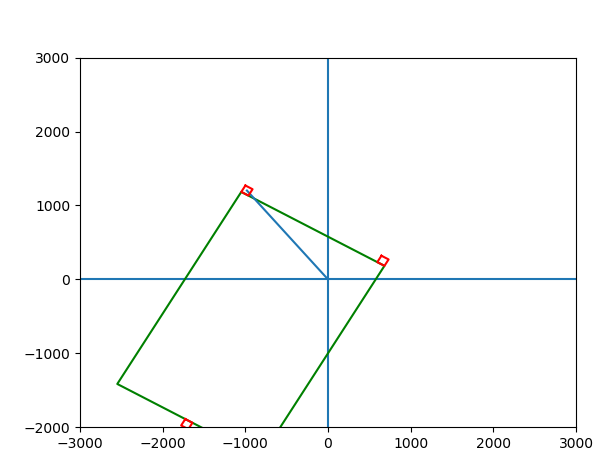

In [20]:
%matplotlib notebook
# table instantiation
table = Table()

table_beacon_1 = Square([Point(-1500 - 100, 2000), Point(-1500, 2000), Point(-1500, 2000 - 100),
                   Point(-1500 - 100, 2000 - 100)])
table_beacon_2 = Square([Point(1500, 1000 + 50), Point(1500 + 100, 1000 + 50), Point(1500 + 100, 1000 - 50),
                   Point(1500, 1000 - 50)])
table_beacon_3 = Square([Point(-1500 - 100, 0 + 100), Point(-1500, 0 + 100), Point(-1500, 0), Point(-1500 - 100, 0)])

table_beacon_1.take_symmetric()
table_beacon_2.take_symmetric()
table_beacon_3.take_symmetric()

table.add_square_obstacle(table_beacon_1)
table.add_square_obstacle(table_beacon_2)
table.add_square_obstacle(table_beacon_3)

table.add_edge_point(Point(-1500, 0))
table.add_edge_point(Point(1500, 0))
table.add_edge_point(Point(1500, 2000))
table.add_edge_point(Point(-1500, 2000))


table.translate(v_robot)

# rotation_angle = 0.5
rotation_angle = np.pi/3
table.rotate(rotation_angle)

# measure = Point(0, 1800)
# measure = translation_vector.apply_to_point(measure)
# measure.rotate(rotation_angle)

table.init_plot()
table.plot_edges()

# table.plot_vector(v_balise)
# table.plot_vector(v_robot)
# table.plot_vector_from_point(v_robot, v_robot_orientation)

# table.plot_vector_from_point(v_robot, v_mesure_balise_1_from_robot)
# v_mesure_balise_1_from_robot.rotate(np.pi/3)
# table.plot_vector_from_point(v_robot, v_mesure_balise_1_from_robot)
v_robot.multiplate_by(-1)
table.plot_vector(v)

table.plot_obstacles()
# table.plot_measures(measure, vectors, robot_vector)
table.plot()

In [21]:
str(v)

'-980.7368354874359 - 1201.3139720814413'

In [22]:
str(v.apply_to_point(Point(beacon_1.x_center, beacon_1.y_center)))


'(569.2631645125641,3151.3139720814415)'

Vecteur du robot vers la balise 1.

In [23]:
v_measure = Vector()
v_measure.set_by_points(unknown_robot_point, beacon_1.center)
print(beacon_1.center)
str(v_measure.apply_to_point(unknown_robot_point))
print(v_measure.x, v_measure.y, v_measure.compute_angle(), v_measure.compute_distance())

(1550.0,1950.0)
550.0 1450.0 1.208252089530389 1550.8062419270823


Table vue dans les coordonnées de la table avec le vecteur du robot, le vecteur de la balise 1 et le vecteur du robot vers la balise 1, ainsi que le vecteur orientation du robot.

<IPython.core.display.Javascript object>


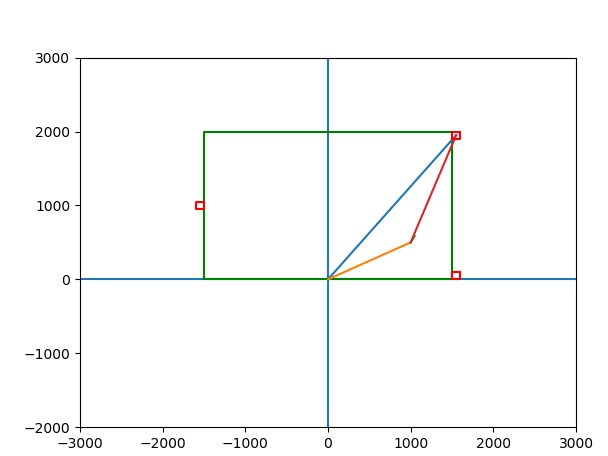

In [24]:
%matplotlib notebook
# table instantiation
table = Table()

table_beacon_1 = Square([Point(-1500 - 100, 2000), Point(-1500, 2000), Point(-1500, 2000 - 100),
                   Point(-1500 - 100, 2000 - 100)])
table_beacon_2 = Square([Point(1500, 1000 + 50), Point(1500 + 100, 1000 + 50), Point(1500 + 100, 1000 - 50),
                   Point(1500, 1000 - 50)])
table_beacon_3 = Square([Point(-1500 - 100, 0 + 100), Point(-1500, 0 + 100), Point(-1500, 0), Point(-1500 - 100, 0)])

table_beacon_1.take_symmetric()
table_beacon_2.take_symmetric()
table_beacon_3.take_symmetric()

table.add_square_obstacle(table_beacon_1)
table.add_square_obstacle(table_beacon_2)
table.add_square_obstacle(table_beacon_3)

table.add_edge_point(Point(-1500, 0))
table.add_edge_point(Point(1500, 0))
table.add_edge_point(Point(1500, 2000))
table.add_edge_point(Point(-1500, 2000))


# table.translate(v_robot)
# rotation_angle = np.pi/3
# table.rotate(rotation_angle)

# measure = Point(0, 1800)
# measure = translation_vector.apply_to_point(measure)
# measure.rotate(rotation_angle)

table.init_plot()
table.plot_edges()

table.plot_vector(v_balise)
table.plot_vector(v_robot)
table.plot_vector_from_point(v_robot, v_robot_orientation)

# table.plot_vector_from_point(v_robot, v_mesure_balise_1_from_robot)
# v_mesure_balise_1_from_robot.rotate(np.pi/3)
table.plot_vector_from_point(v_robot, v_measure)


# table.plot_vector_from_point(v_robot, v_measure)

table.plot_obstacles()
# table.plot_measures(measure, vectors, robot_vector)
table.plot()

In [25]:
str(unknown_robot_point)

'(1000,500)'

In [26]:
str(coordinates_from_robot)

'(550.0,1450.0)'

In [27]:
str(estimated_beacon_position)

'(1550.0,1950.0)'

In [28]:
estimated_beacon_position.y

1950.0

In [29]:
str(v.apply_to_point(unknown_robot_point))

'(19.263164512564117,1701.3139720814413)'

## On ne connaît la position que d'une balise

## Avec de vraies données

In [30]:
from src.script_28_04_2019 import display_just_measures

<IPython.core.display.Javascript object>


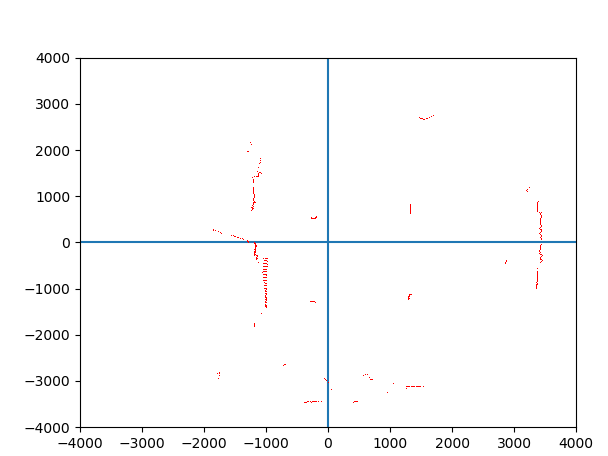

In [31]:
%matplotlib notebook

samples = ["0_-1820_pi_over_2", "1210_1400_pi", "-1210_1400_0"]
one_turn_measure = get_table_measures(samples[1])
one_turn_measure = dacl.keep_good_measures(one_turn_measure[0], 100)
one_turn_measure = dacl.keep_not_too_far_or_not_too_close(one_turn_measure)
chh.display_measures(one_turn_measure)

<IPython.core.display.Javascript object>


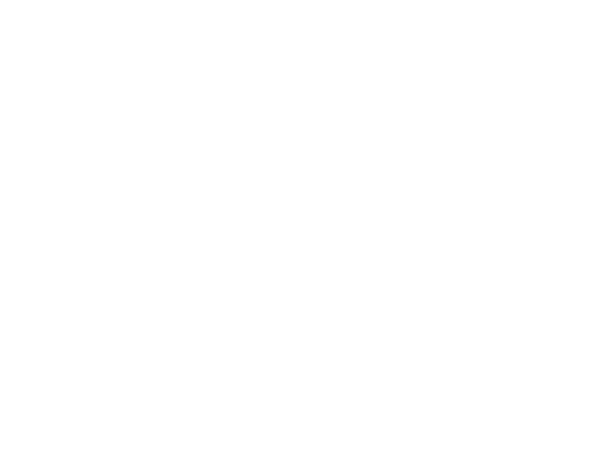

In [32]:
%matplotlib notebook
display_just_measures()

1. On récupère les position des 3 balises, par exemple.
2. On les note dans des Points dans le référentiel du robot.
3. On note les positions des Points dans le référentiel de la table.
4. On note la position et l'orientation du robot.
5. On fait un changement de repère du robot vers la table.
6. On affiche les mesures dans le repère de la table et on vérifie que les positions affichées des balises sont bien celles que l'on devrait avoir.

In [33]:
# 1
beacon_1 = clus.Beacon()
beacon_1.set_by_upper_left_and_lower_right(beacons_purple[0][0], beacons_purple[0][1])
beacon_1.set_radius(FIX_BEACON_RADIUS)
beacon_1_point = beacon_1.center

beacon_2 = clus.Beacon()
beacon_2.set_by_upper_left_and_lower_right(beacons_purple[1][0], beacons_purple[1][1])
beacon_2.set_index(1)
beacon_2.set_radius(FIX_BEACON_RADIUS)
beacon_2_point = beacon_2.center

beacon_3 = clus.Beacon()
beacon_3.set_by_upper_left_and_lower_right(beacons_purple[2][0], beacons_purple[2][1])
beacon_3.set_index(2)
beacon_3.set_radius(FIX_BEACON_RADIUS)
beacon_3_point = beacon_3.center

beacons = [beacon_1, beacon_2, beacon_3]


perceived_theta_1 = 1.44*np.pi
perceived_rho_1 = 1346
perceived_theta_2 = 1.953*np.pi
perceived_rho_2 = 2970
perceived_theta_3 = 0.630*np.pi
perceived_rho_3 = 622

# x1 = np.cos(perceived_theta_1)*perceived_rho_1
# y1 = np.sin(perceived_theta_1)*perceived_rho_1
# x2 = np.cos(perceived_theta_2)*perceived_rho_2
# y2 = np.sin(perceived_theta_2)*perceived_rho_2
# x3 = np.cos(perceived_theta_3)*perceived_rho_3
# y3 = np.sin(perceived_theta_3)*perceived_rho_3

x1 = -275
y1 = -1377
x2 = 2948
y2 = -464
x3 = -240
y3 = 675

perceived_beacon_1 = Point(x1, y1)
perceived_beacon_2 = Point(x2, y2)
perceived_beacon_3 = Point(x3, y3)





On sait que notre robot avait la position (1210, 1400) et l'orientation pi rad (soit 180°).

In [34]:
robot_position = Point(1210-120, 1400)
orientation = np.pi

Un changement de repère du robot vers la table se fait de la manière suivante :

- rotation d'angle "- orientation" du robot,
- puis translation de plus le vecteur position du robot.

In [35]:
perceived_beacon_1.rotate(-orientation)
perceived_beacon_2.rotate(-orientation)
perceived_beacon_3.rotate(-orientation)

diff_1 = beacon_1_point - perceived_beacon_1
diff_2 = beacon_2_point - perceived_beacon_2
diff_3 = beacon_3_point - perceived_beacon_3
print(str(diff_1), str(diff_2), str(diff_3))

b1 = perceived_beacon_1 + robot_position
b2 = perceived_beacon_2 + robot_position
b3 = perceived_beacon_3 + robot_position


(1275.0000000000002,573.0) (1398.0,536.0000000000003) (1310.0,725.0)


In [36]:
str(b1), str(b2), str(b3)

('(1364.9999999999998,2777.0)',
 '(-1858.0,1863.9999999999995)',
 '(1330.0,725.0)')

In [37]:
str(beacon_1_point - b1), str(beacon_2_point - b2), str(beacon_3_point - b3)

('(185.00000000000023,-827.0)', '(308.0,-863.9999999999995)', '(220.0,-675.0)')

<IPython.core.display.Javascript object>


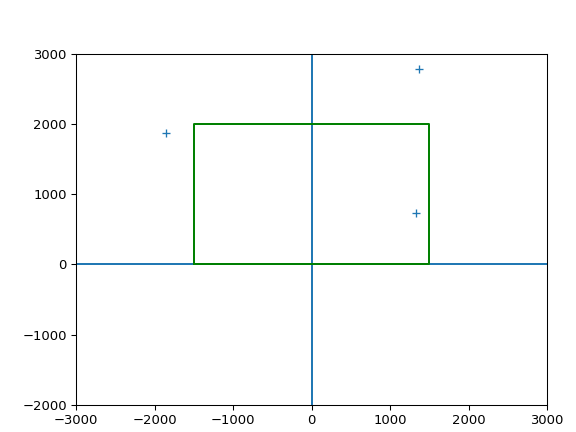

vectors
points
1364.9999999999998 2777.0
-1858.0 1863.9999999999995
1330.0 725.0


In [40]:

# table instantiation
table = Table()
table.add_edge_point(Point(-1500, 0))
table.add_edge_point(Point(1500, 0))
table.add_edge_point(Point(1500, 2000))
table.add_edge_point(Point(-1500, 2000))

table.add_point(b1)
table.add_point(b2)
table.add_point(b3)


table.init_plot()
table.plot_edges()
table.plot_vectors()
table.plot_points()

# table.plot_point(robot_position)
# table.plot_unitary_vector(robot_position, orientation)
# table.plot_point(opponent_position)


# table.plot_measures(measure, vectors, robot_vector)
table.plot()

<IPython.core.display.Javascript object>


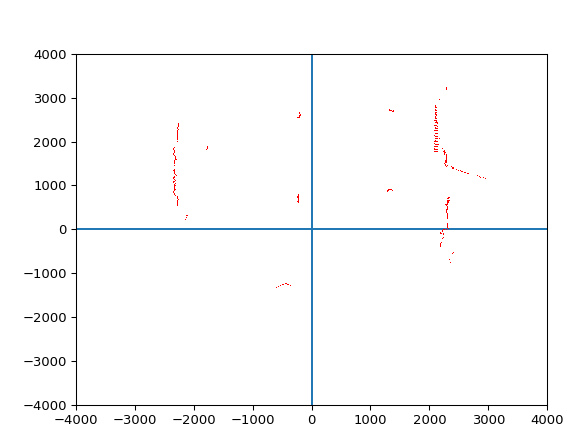

In [39]:
%matplotlib notebook

samples = ["0_-1820_pi_over_2", "1210_1400_pi", "-1210_1400_0"]
one_turn_measure = get_table_measures(samples[1])
one_turn_measure = dacl.keep_good_measures(one_turn_measure[0], 100)
one_turn_measure = dacl.keep_not_too_far_or_not_too_close(one_turn_measure)
one_turn_measure = outr.one_turn_to_cartesian_points(one_turn_measure)

# --------------------------------------
def change_basis(rp, ori, measures):
#     measures = outr.one_turn_to_cartesian_points(measures)
    new_measures = []
    for measure in measures:
        p = Point(measure[0], measure[1])
        p.rotate(-ori)
        new_measure = p + rp
        new_measures.append([new_measure.x, new_measure.y])
    return new_measures
        
new_one_turn_measure = change_basis(robot_position, orientation, one_turn_measure)

# --------------------------------------
fig = pl.figure()
ax = fig.add_subplot(111)
ax.clear()
ax.set_xlim(-distance_max_x_cartesien, distance_max_x_cartesien)
ax.set_ylim(-distance_max_y_cartesien, distance_max_y_cartesien)
ax.axhline(0, 0)
ax.axvline(0, 0)
# pl.grid()


xx = []
yy = []
for x, y in new_one_turn_measure:
    xx.append(x)
    yy.append(y)

pl.plot(xx, yy, 'r,')
fig.canvas.draw()
pl.show()

Par Clément Besnier, www.clementbesnier.fr